In [1]:
path = '/Users/karl/Documents/Workspace/415/Assignment 3/A3-W24-images'


# CIFAR10


# 1.1 : Compute HoG features with cells of 8x8 pixels, blocks of 4x4 cells, and 4 bins

In [2]:
import numpy as np
import cv2
from skimage.feature import hog 
from torchvision.datasets import CIFAR10
# import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Load CIFAR10 dataset
# transform = transforms.Compose([transforms.Resize((64, 64))])
train_dataset = CIFAR10(root='./data', train=True, download=True)
test_dataset = CIFAR10(root='./data', train=False, download=True)

# Define the size of the subset
data_subset_size = 5000  # Reduced from 5000
test_subset_size = 1000  # Reduced from 1000

# Randomly sample a subset from the original dataset
train_subset_indices = np.random.choice(len(train_dataset), size=data_subset_size, replace=False)
test_subset_indices = np.random.choice(len(test_dataset), size=test_subset_size, replace=False)

# Create subset datasets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

# Function to resize images to 64x64 and convert to grayscale
def preprocess_images(parent_dataset, subset_dataset):
    images = []
    for idx in subset_dataset.indices:
        img, temp = parent_dataset[idx]  # Access image and label from parent dataset
        # Resize image to 64x64 and convert to grayscale
        img = cv2.resize(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY), (64, 64))
        images.append(img)
    return np.array(images)

# Extract labels for the train and test subsets
train_labels = [train_dataset.targets[i] for i in train_subset_indices]
test_labels = [test_dataset.targets[i] for i in test_subset_indices]

# Convert labels to a numpy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Preprocess train and test images
train_images = preprocess_images(train_dataset, train_subset)
test_images = preprocess_images(test_dataset, test_subset)

# Function to compute HoG features
def compute_hog_features(dataloader):
    hog_features = []
    for images in dataloader:        
        # Compute HoG features
        features = hog(images, pixels_per_cell=(8, 8), cells_per_block=(4, 4), orientations=4, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Compute HoG features for train and test images
train_hog_features = compute_hog_features(train_images)
test_hog_features = compute_hog_features(test_images)

# Print the shapes of train and test HoG features
print("Train HoG features shape:", train_hog_features.shape)
print("Test HoG features shape:", test_hog_features.shape)

Files already downloaded and verified
Files already downloaded and verified
Train HoG features shape: (5000, 1600)
Test HoG features shape: (1000, 1600)


# 1.2-3 Fit a non-linear SVM classifier and Prediction of labels of the test images

In [3]:
# Fit a non-linear SVM classifier
svm_classifier = SVC()
svm_classifier.fit(train_hog_features, train_labels)

# Predict the labels of the test set
test_predictions = svm_classifier.predict(test_hog_features)

# Calculate the classification accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Classification accuracy on the test set: {accuracy:.4f}')

Classification accuracy on the test set: 0.5120


# 1.4 Tune values of hyperparameters ’gamma’ and ’C’

In [4]:
# Define the parameter grid
parameters = {
    'C': [0.1, 1, 10, 100],  # Example values for C
    'gamma': [0.001, 0.01, 0.1, 1]  # Example values for gamma
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(SVC(), parameters, refit=True, verbose=1, cv=5)

# Fit the model with the grid search
grid_search.fit(train_hog_features, train_labels)

# Print out the best parameters and the corresponding accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

# Predict the labels of the test set with the best estimator found in the grid search
best_test_predictions = grid_search.best_estimator_.predict(test_hog_features)

# Calculate the classification accuracy with the best estimator
best_accuracy = accuracy_score(test_labels, best_test_predictions)
print(f'Best classification accuracy on the test set: {best_accuracy:.4f}')

# Display all the grid pairs with their corresponding mean test scores
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"{param} -> Mean accuracy: {mean:.3f} (std: {std:.3f})")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'C': 10, 'gamma': 0.1}
Best cross-validated score:  0.5242
Best classification accuracy on the test set: 0.5220
{'C': 0.1, 'gamma': 0.001} -> Mean accuracy: 0.108 (std: 0.000)
{'C': 0.1, 'gamma': 0.01} -> Mean accuracy: 0.236 (std: 0.007)
{'C': 0.1, 'gamma': 0.1} -> Mean accuracy: 0.365 (std: 0.017)
{'C': 0.1, 'gamma': 1} -> Mean accuracy: 0.108 (std: 0.000)
{'C': 1, 'gamma': 0.001} -> Mean accuracy: 0.252 (std: 0.007)
{'C': 1, 'gamma': 0.01} -> Mean accuracy: 0.455 (std: 0.005)
{'C': 1, 'gamma': 0.1} -> Mean accuracy: 0.516 (std: 0.016)
{'C': 1, 'gamma': 1} -> Mean accuracy: 0.110 (std: 0.000)
{'C': 10, 'gamma': 0.001} -> Mean accuracy: 0.453 (std: 0.006)
{'C': 10, 'gamma': 0.01} -> Mean accuracy: 0.473 (std: 0.006)
{'C': 10, 'gamma': 0.1} -> Mean accuracy: 0.524 (std: 0.013)
{'C': 10, 'gamma': 1} -> Mean accuracy: 0.110 (std: 0.000)
{'C': 100, 'gamma': 0.001} -> Mean accuracy: 0.456 (std: 0.005)
{'C

# 1.5-6 Random Forest classifier and Prediction of labels of the test images

In [5]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy')

# Fit the RF classifier on the training data
rf_classifier.fit(train_hog_features, train_labels)

# Predict the labels of the test images
rf_test_predictions = rf_classifier.predict(test_hog_features)

# Calculate the classification accuracy of the RF classifier
rf_accuracy = accuracy_score(test_labels, rf_test_predictions)
print(f"Classification accuracy of the Random Forest classifier on the test set: {rf_accuracy:.4f}")


Classification accuracy of the Random Forest classifier on the test set: 0.2900


# 1.7 Compare the performance of SVM and RF

In [6]:
random_states = range(10)
svm_accuracies = []
rf_accuracies = []

for state in random_states:
    # Train and evaluate SVM
    svm_classifier = SVC(random_state=state)
    svm_classifier.fit(train_hog_features, train_labels)
    svm_predictions = svm_classifier.predict(test_hog_features)
    svm_acc = accuracy_score(test_labels, svm_predictions)
    svm_accuracies.append(svm_acc)
    
    # Train and evaluate RF
    rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy', random_state=state)
    rf_classifier.fit(train_hog_features, train_labels)
    rf_predictions = rf_classifier.predict(test_hog_features)
    rf_acc = accuracy_score(test_labels, rf_predictions)
    rf_accuracies.append(rf_acc)


# Calculate mean accuracy for each classifier
svm_mean_accuracy = np.mean(svm_accuracies)
svm_std_accuracy = np.std(svm_accuracies)

rf_mean_accuracy = np.mean(rf_accuracies)
rf_std_accuracy = np.std(rf_accuracies)

# Print accuracies
print("SVM Accuracies:", svm_accuracies)
print("RF Accuracies:", rf_accuracies)

print(f"SVM Mean accuracy: {svm_mean_accuracy:.4f} (std: {svm_std_accuracy:.4f})")
print(f"RF Mean accuracy: {rf_mean_accuracy:.4f} (std: {rf_std_accuracy:.4f}")

SVM Accuracies: [0.512, 0.512, 0.512, 0.512, 0.512, 0.512, 0.512, 0.512, 0.512, 0.512]
RF Accuracies: [0.298, 0.311, 0.297, 0.314, 0.316, 0.314, 0.315, 0.315, 0.318, 0.295]
SVM Mean accuracy: 0.5120 (std: 0.0000)
RF Mean accuracy: 0.3093 (std: 0.0085



SVM:

    Strengths:
        Effective in high-dimensional spaces.
        Works well with a clear margin of separation and is effective in cases where the number of dimensions exceeds the number of samples.
        Provides flexibility through the use of different kernel functions.

    Weaknesses:
        Requires careful normalization and choice of kernel.
        Poor performance with noisy datasets and overlapping classes.
        Training time is cubic in the size of the dataset, making it hard to scale to large datasets.

Random Forest:

    Strengths:
        Handles categorical and numerical features well.
        Less likely to overfit than a decision tree.
        Good performance and generalization capability across a variety of datasets without extensive parameter tuning.
        Can handle missing values and maintain accuracy for large proportion of missing data.

    Weaknesses:
        Complexity can lead to longer training times compared to some other algorithms.
        Predictions are not as interpretable as those of decision trees.

Stability Evaluation

By comparing the variance in accuracies across the different random_state values, we can evaluate the stability of each model. A model with less variance in its accuracy across different random_state values is considered more stable. This experiment will likely show that while both models have their strengths and weaknesses, RF might exhibit more stability across different initializations due to its ensemble nature, averaging out the predictions over many trees. In contrast, the performance of SVM might be more sensitive to the choice of kernel and its parameters.

# Face Detection

# 2.1 Import images

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_files = [ path + f'/Q2 part1/{i:06d}.jpg' for i in range(1, 101)]

# Function to read and convert an image to grayscale
def load_image(file_path):
    # Read the image
    image = cv2.imread(file_path)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

# Load all images and convert them to grayscale
grayscale_images = [load_image(file) for file in image_files]


# 2.2 PCA

Displaying the first 5 eigenfaces for Question 2.2


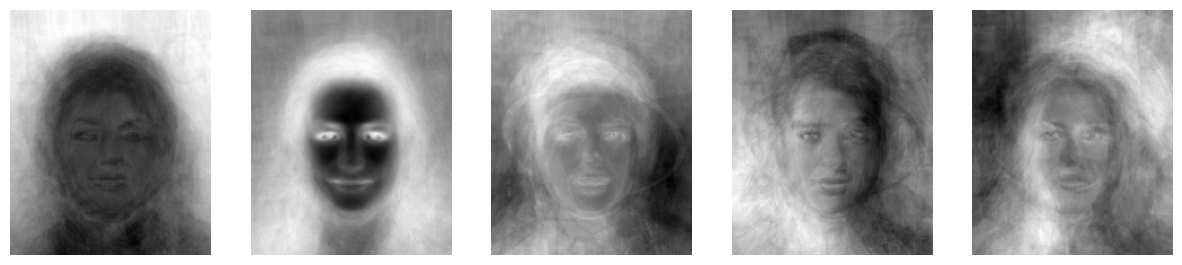

In [8]:
def PCA(images):
    # Step 1: Flatten the images and create the data matrix
    vectors = np.asarray([img.flatten() for img in images])
    vectors = np.transpose(vectors)

    # Step 2: Compute the mean face and normalize the data
    mean = np.mean(vectors, axis=0)
    mean_face = vectors - mean

    # Step 3: Compute the covariance matrix
    cov_matrix = np.cov(mean_face, rowvar=False)

    # Step 4: Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Step 5: Sort the eigenvectors by descending eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvalues, eigenvectors, sorted_indices, mean, mean_face, vectors


eigenvalues, eigenvectors, sorted_indices, mean, mean_face, vectors = PCA(grayscale_images)



eigenfaces = np.dot(eigenvectors.transpose(), mean_face.transpose())

# Step 6: Select the top eigenvectors (e.g., for the 5 best eigenfaces)
top_eigenvectors = eigenvectors[:, :5]

# Step 7: Compute the eigenfaces from the top eigenvectors
# To get the actual eigenvectors of the data in the original high-dimensional space,
# we need to project the top eigenvectors back to this space.
D_T = mean_face.T  # Transpose of D
eigenfaces = np.dot(vectors, eigenvectors)

# Display Eigenfaces
print("Displaying the first 5 eigenfaces for Question 2.2")


fig, axarr = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axarr[i].imshow(eigenfaces[:, i].reshape(grayscale_images[0].shape), cmap='gray')
    axarr[i].axis('off')
plt.show()

# 2.3 - 4 Sliding Window and Threshold 

In [9]:
import matplotlib.patches as patches

# Load the test image
person_path = path + '/Q2 part2/Person.png'
test_image = cv2.imread(person_path)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)


In [10]:
def sliding_window(image, stepSize, windowSize):
    # Slide a window across the image
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


def detect_face(window, vectors, mean):
    
    #Flatten and normalize the window
    window_flat = window.flatten()
    window_normalized = window_flat - mean

    diff= np.sum((vectors.transpose().dot(mean)).dot(vectors))

    # Compute the reconstruction error
    error = np.linalg.norm(window_normalized - diff)

    return error


threshold = 6834055
windowSize = (600, 600) 
stepSize = 600 
mean = np.mean(vectors.flatten(), axis = 0) #flatten the mean to be able to subtract from flattened window

# Placeholder for detected faces
detected_faces = []

# Debugging: Collect errors for analysis
errors = []
for (x, y, window) in sliding_window(test_image_gray, stepSize, windowSize):

    # Detect face in the window
    error = detect_face(window, eigenvectors, mean)
    errors.append(error)

    if error < threshold:
        detected_faces.append((x, y, windowSize[0], windowSize[1]))

# 2.5 Output of face detection

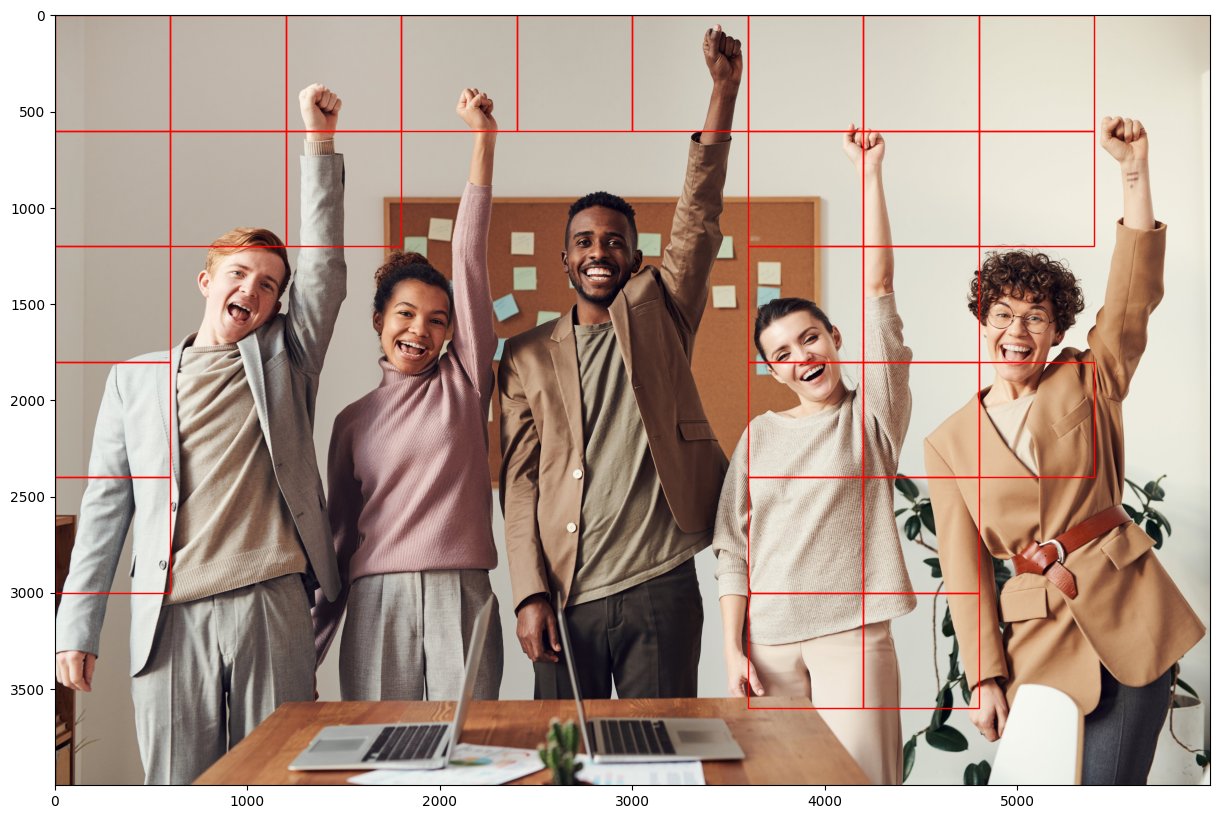

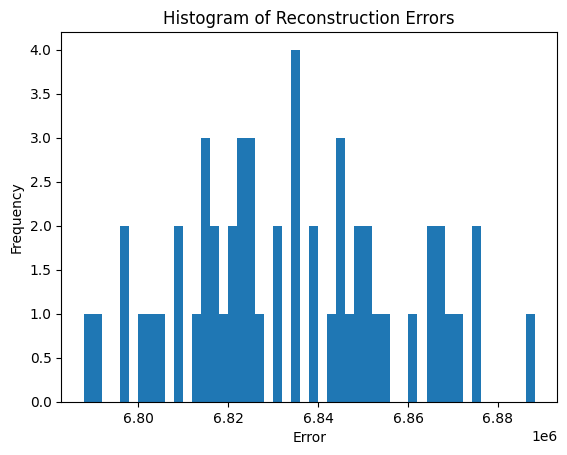

Error statistics: Min=6787835.174445658, Max=6888195.1039993055, Mean=6834055.312642253, Std=23802.929206534664


In [11]:

original_image = cv2.imread(person_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying

# Draw bounding boxes for the detections
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(original_image, cmap='gray')
for (x, y, w, h) in detected_faces:
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

plt.show()
#This was used to find the optimal threshold
errors = np.array(errors)
# plot a histogram of the reconstruction errors
plt.hist(errors, bins=50)
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()
print("Error statistics: Min={}, Max={}, Mean={}, Std={}".format(errors.min(), errors.max(), errors.mean(), errors.std()))


# 2.6 Viola Jones

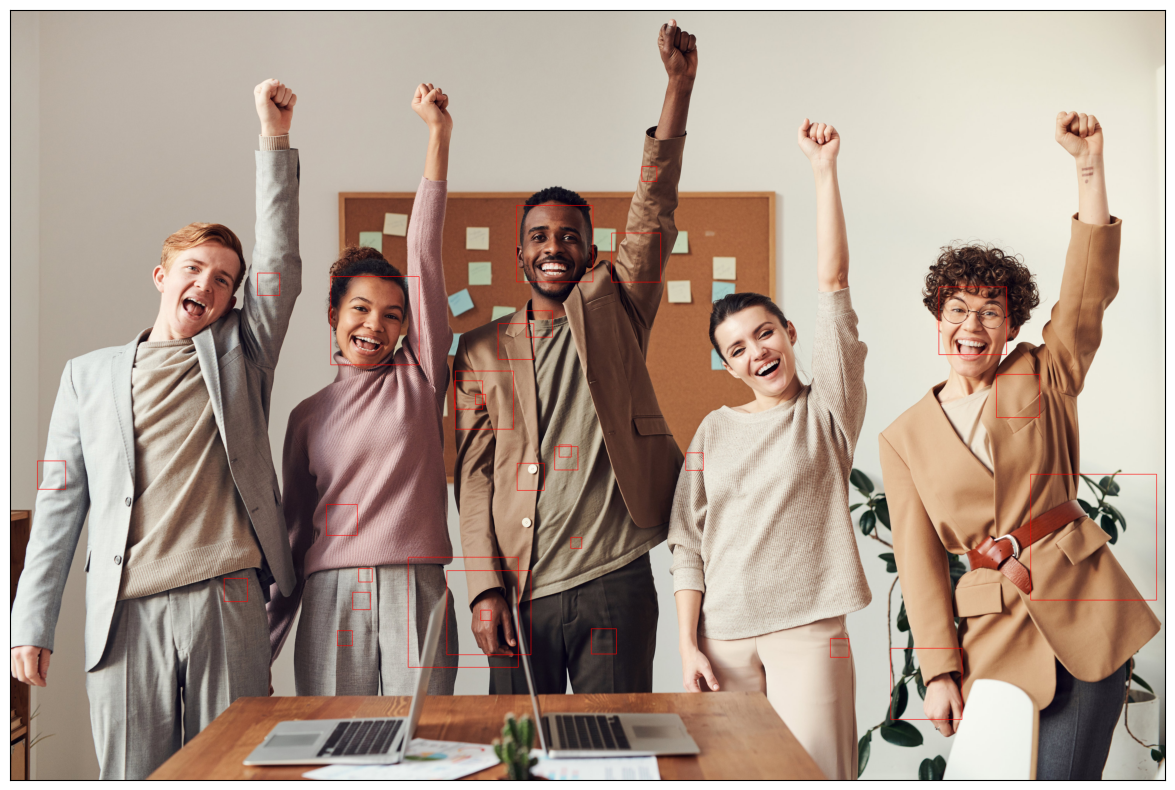

In [12]:
original_image = cv2.imread(person_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying

# Load the pre-trained Viola-Jones face detector model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces using the Viola-Jones detector
faces_viola_jones = face_cascade.detectMultiScale(original_image, 1.1, 2)

# Draw bounding boxes for Viola-Jones detections
for (x, y, w, h) in faces_viola_jones:
    
    if w > 50 and h > 50:
        original_image = cv2.rectangle(original_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Display the image with Viola-Jones detections
plt.subplots(1, figsize=(15, 10))    
plt.imshow(original_image, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()



# 2.7 Evaluation of methods

We can see that the PCA algorithm is worse than the viola jones.  

PCA:  

True Positives: The PCA method correctly identified only 1 face. This suggests that the PCA model was able to match one instance where the facial features closely resembled the eigenfaces generated from the training set.  
False Positives: All other detected boxes were false positives. This high rate may indicate that the eigenfaces did not capture the necessary variance to distinguish faces from non-faces effectively.  
This may be due to:  
    Insufficient Training Data: If the training set is too small, the PCA model might not generalize well, leading to poor detection on new images.  
    Lack of Variability: If the training images lack variability (e.g., in terms of poses, expressions, lighting conditions), the model may fail to recognize faces that deviate from the training conditions.  
    Threshold Selection: The selection of the threshold is critical in determining the sensitivity and specificity of the detection. A suboptimal threshold can result in a high number of false positives or negatives.  
    Face Orientation and Scale: PCA is sensitive to the orientation and scale of the faces. If the faces in the test image are at a different scale or orientation than the training images, PCA might fail to detect them.  

Viola Jones:  

True Positives: The Viola-Jones method identified 3 faces correctly, indicating a better performance in terms of true positives.  
False Positives: There are still some false positives, but the number is lower compared to the PCA method.  
Strengths:  
    Robust Feature Selection: uses Haar-like features, which are effective at capturing the presence of facial features.  
    Integral Images: use of integral images allows for rapid feature detection, making it suitable for real-time applications.  
    Adaptive Learning: uses a cascading classifier that can be trained to improve detection over time.  
    Scale Invariance: employs an image pyramid to detect faces at multiple scales, making it more robust to face size variations.  


# 2.8 Viola Jones vs PCA

The Viola-Jones detector is a robust method that uses Haar features and is particularly good at detecting faces under various lighting conditions and orientations when the face is relatively upright and frontal. It's also designed to quickly discard non-face regions, making it efficient for real-time detection.  
PCA, may not perform well if the faces in the test image have different orientations, expressions, or lighting conditions than the faces in the training set. PCA-based detection can also struggle with scale variations and occlusions.  
Viola-Jones may work when PCA does not because it doesn't rely on a linear combination of training images. Instead, it uses a cascaded classifier trained on simple feature differences that may generalize better to new faces or varied conditions.  

# 2.9 Evaluation of model

PCA method:  

    Computing the PCA on the training set to obtain eigenfaces.  
    Projecting the test image windows onto the PCA space to get their coefficients.  
    Reconstructing the windows from these coefficients.  
    Calculating the reconstruction error for each window.  
    Detecting faces based on a threshold applied to these errors.  

network like viola jones:  

    Applying the integral image concept to compute features quickly.  
    Using AdaBoost to select the best features and train the classifier.  
    Employing a cascade of classifiers to rapidly discard non-face regions and focus on promising regions for more refined analysis.  